In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import statsmodels.stats.weightstats as wst
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
PASSIVE_COLOR = 'k'#'#505050'
GOOD_GREEN = '#32A852'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
#PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#V1
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V2

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']

retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate = ['BS_139','BS_165','BS_191','BS_192']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28','DS_16','DS_17','DS_22','DS_13','DS_23']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
stim25sopsinondecodingfilename = 'D:\\stimdecoding_25s_opsin_on.csv'
stim25sopsinoffdecodingfilename = 'D:\\stimdecoding_25s_opsin_off.csv'

current_version = 0 #June 22nd, 2023
current_version = 1 #June 28th, 2023
current_version = 2 #July 11th, 2023
current_version = 3 #July 13th, 2023
current_version = 4 #Sept 14th, 2023
current_version = 5 #Oct 25th, 2023
current_version = 6 #Nov 6th, 2023

stdfont = 14
stdyfrac = 0.06

In [2]:
animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))

In [3]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Fetching files for DS_19
Fetching files for DS_22
Fetching files for DS_23
Fetching files for DS_24
Fetching files for DS_27
Fetching files for DS_28
Fetching files for DS_13
Fetching files for BS_173
Fetching files for BS_175
Fetching files for BS_187
Fetching files for BS_188
Fetching files for BS_213
Fetching files for BS_214
Fetching files for TH_217
Fetching files for AE_235
Fetching files for AE_236
Fetching files for TH_237
Fetching files for AE_252
Fetching files for AE_254
Fetching files for AE_238
Fetching files for AE_239
Fetching files for AE_240
Fetching files for AE_267
Fetching files for AO_273
Fetching files for AO_274
Fetching files for AE_287
Fetching files for AE_301
Fetching files for AE_312
P:\Behavioor\BS_61\behavior\BS_61_42v2_reversal.txt: No columns to parse from file
P:\Behavioor\BS_103\behavior\BS_103_11v4_opto.txt: No columns to parse from file
Error loading P:\Behavioor\BS_123\behavior\BS_123_18v1_opto.txt: No columns to parse from file
P:\Behavioor\BS_123\

../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scala

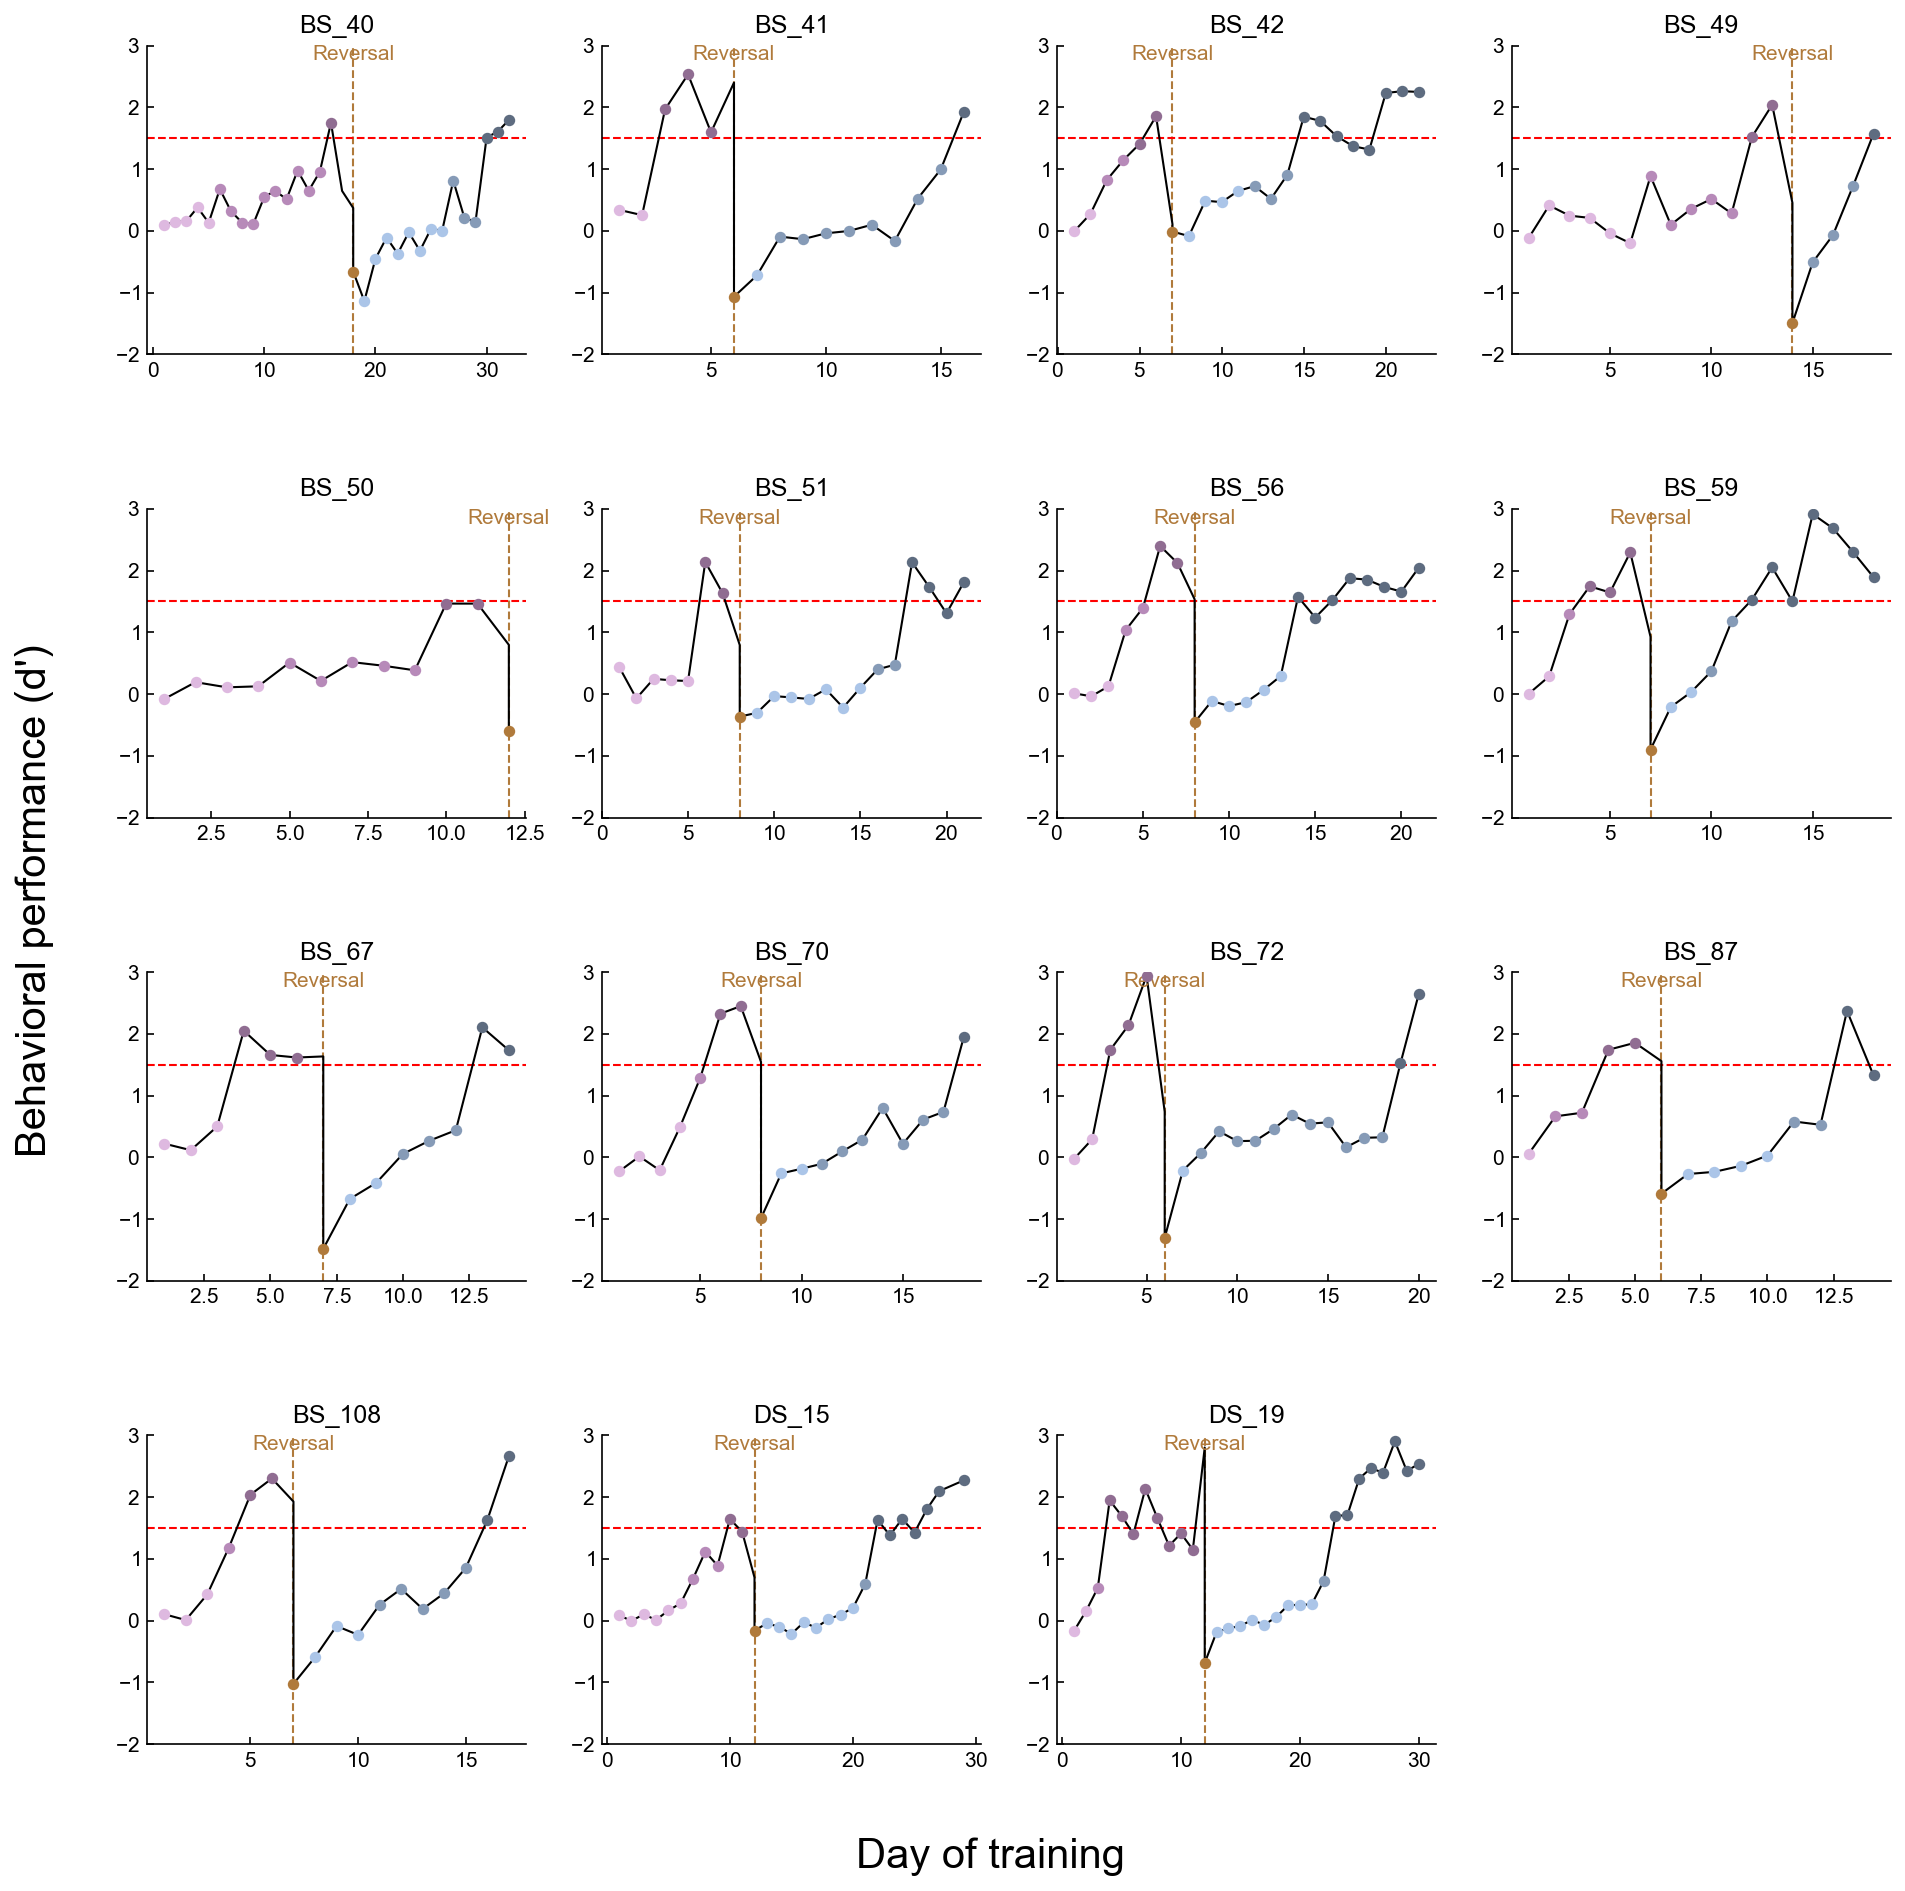

In [4]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [5]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no behavior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 740/740 [00:07<00:00, 93.72it/s] 


In [6]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1829/1829 [00:26<00:00, 67.84it/s] 

errors for: []


In [7]:
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []

# RampingNorm_preearly = []
# RampingNorm_prelate = []
# RampingNorm_preexpert = []
# RampingNorm_postearly = []
# RampingNorm_postlate = []
# RampingNorm_postexpert = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
    
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    except Exception as e:
        print(e)
        FRmod = np.nan
    
    if EILphases[idx] == 'pre early':
        FRmod_preearly.append(FRmod)
#         RampingNorm_preearly.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        FRmod_prelate.append(FRmod)
#         RampingNorm_prelate.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        FRmod_preexpert.append(FRmod)
#         RampingNorm_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        FRmod_postearly.append(FRmod)
#         RampingNorm_postearly.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        FRmod_postlate.append(FRmod)
#         RampingNorm_postlate.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        FRmod_postexpert.append(FRmod)
#         RampingNorm_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        postexpert_animals.append(sessionfile.meta.animal)

FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

# RampingNorm_preearly = np.array(RampingNorm_preearly)
# RampingNorm_prelate = np.array(RampingNorm_prelate)
# RampingNorm_preexpert = np.array(RampingNorm_preexpert)
# RampingNorm_postearly = np.array(RampingNorm_postearly)
# RampingNorm_postlate = np.array(RampingNorm_postlate)
# RampingNorm_postexpert = np.array(RampingNorm_postexpert)

1829it [00:27, 66.00it/s] 


Load Passive data: from TH notebook

In [8]:
animals_in_cache = []

EnumACSession = []
EnumACClust = []

for session in tqdm(os.listdir(act_directory)):
    
    if session in ['TH_203_1_passive_AC.pickle','TH_203_4_passive_AC.pickle','TH_203_7_passive_AC.pickle','session LA_204_4_passive_AC.pickle']:#Outlier sessions
            continue
    
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.animal not in ['TH_201','TH_203','LA_204','LA_205','TH_200', 'TH_230','AE_229','TH_233','TH_234','AE_294']:
        continue
    
    animals_in_cache.append(sessionfile.meta.animal)
    
    for clust in sessionfile.clusters.good:
        if sessionfile.meta.region == "AC":
            EnumACSession.append(session)
            EnumACClust.append(clust)
        
animals_in_cache = np.unique(animals_in_cache)

100%|██████████| 740/740 [00:07<00:00, 93.66it/s] 


In [9]:
#Define 6 learning phases(days)
pre_early = 4
pre_late = 6
pre_expert = 8
post_early = 12
post_late = 15
post_expert = 16

#
FRmod_passive_preearly = []
FRmod_passive_prelate = []
FRmod_passive_preexpert = []
FRmod_passive_postearly = []
FRmod_passive_postlate = []
FRmod_passive_postexpert = []

#
preexpert_session_num = []
postlate_session_num = []
postexpert_session_num = []


In [10]:
preearly_passive_animal = []
prelate_passive_animal = []
preexpert_passive_animal = []
postearly_passive_animal = []
postlate_passive_animal = []
postexpert_passive_animal = []


for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    ACsessionfile = ilep.loadSessionCached(act_directory,session)
    
    #1,2,3,4
    if ACsessionfile.meta.day_of_training <= pre_early:
        FRmod_passive_preearly.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        preearly_passive_animal.append(ACsessionfile.meta.animal)
        
        
    #5,6
    if ACsessionfile.meta.day_of_training <= pre_late and ACsessionfile.meta.day_of_training >pre_early:
        FRmod_passive_prelate.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        prelate_passive_animal.append(ACsessionfile.meta.animal)
    
    #7,8
    if ACsessionfile.meta.day_of_training <= pre_expert and ACsessionfile.meta.day_of_training >pre_late:
        FRmod_passive_preexpert.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        preexpert_session_num.append(ACsessionfile.meta.files)
        preexpert_passive_animal.append(ACsessionfile.meta.animal)
        
    #9,10,11,12
    if ACsessionfile.meta.day_of_training <= post_early and ACsessionfile.meta.day_of_training >pre_expert:
        FRmod_passive_postearly.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postearly_passive_animal.append(ACsessionfile.meta.animal)

    #13,14,15
    if ACsessionfile.meta.day_of_training <= post_late and ACsessionfile.meta.day_of_training >post_early:
        FRmod_passive_postlate.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postlate_session_num.append(ACsessionfile.meta.files)
        postlate_passive_animal.append(ACsessionfile.meta.animal)
    
    #16,17,18,19,20,21
    if ACsessionfile.meta.day_of_training >= post_expert:
        FRmod_passive_postexpert.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postexpert_session_num.append(ACsessionfile.meta.files)
        postexpert_passive_animal.append(ACsessionfile.meta.animal)
    

1608it [00:13, 122.79it/s]


In [11]:
#number of animals in each learning phase

preearly_passive_animal = np.unique(preearly_passive_animal)
prelate_passive_animal = np.unique(prelate_passive_animal)
preexpert_passive_animal = np.unique(preexpert_passive_animal)
postearly_passive_animal = np.unique(postearly_passive_animal)
postlate_passive_animal = np.unique(postlate_passive_animal)
postexpert_passive_animal = np.unique(postexpert_passive_animal)

preearly_passive_animal_num = len(preearly_passive_animal)
prelate_passive_animal_num = len(prelate_passive_animal)
preexpert_passive_animal_num = len(preexpert_passive_animal)
postearly_passive_animal_num = len(postearly_passive_animal)
postlate_passive_animal_num = len(postlate_passive_animal)
postexpert_passive_animal_num = len(postexpert_passive_animal)

In [12]:
FRmod_passive_preearly = np.array(FRmod_passive_preearly)
FRmod_passive_prelate = np.array(FRmod_passive_prelate)
FRmod_passive_preexpert = np.array(FRmod_passive_preexpert)
FRmod_passive_postearly = np.array(FRmod_passive_postearly)
FRmod_passive_postlate = np.array(FRmod_passive_postlate)
FRmod_passive_postexpert = np.array(FRmod_passive_postexpert)

In [123]:
FRmod_baseline_median = 3.5
print('baseline: '+str(FRmod_baseline_median))

#These numbers are essentially %CR
FRmod_preearly_pc = np.mean(np.greater(ilep.rmnan(FRmod_preearly),FRmod_baseline_median))
FRmod_prelate_pc = np.mean(np.greater(ilep.rmnan(FRmod_prelate),FRmod_baseline_median))
FRmod_preexpert_pc = np.mean(np.greater(ilep.rmnan(FRmod_preexpert),FRmod_baseline_median))
FRmod_postearly_pc = np.mean(np.greater(ilep.rmnan(FRmod_postearly),FRmod_baseline_median))
FRmod_postlate_pc = np.mean(np.greater(ilep.rmnan(FRmod_postlate),FRmod_baseline_median))
FRmod_postexpert_pc = np.mean(np.greater(ilep.rmnan(FRmod_postexpert),FRmod_baseline_median))
print(FRmod_preearly_pc)
print(FRmod_prelate_pc)
print(FRmod_preexpert_pc)
print(FRmod_postearly_pc)
print(FRmod_postlate_pc)
print(FRmod_postexpert_pc)

print()
FRmod_passive_baseline_median = 3.5#np.median(FRmod_passive_preearly)
print('baseline_passive: '+str(FRmod_passive_baseline_median))

#These numbers are essentially %CR
FRmod_passive_preearly_pc = np.nanmean(np.greater(FRmod_passive_preearly,FRmod_passive_baseline_median))
FRmod_passive_prelate_pc = np.nanmean(np.greater(FRmod_passive_prelate,FRmod_passive_baseline_median))
FRmod_passive_preexpert_pc = np.nanmean(np.greater(FRmod_passive_preexpert,FRmod_passive_baseline_median))
FRmod_passive_postearly_pc = np.nanmean(np.greater(FRmod_passive_postearly,FRmod_passive_baseline_median))
FRmod_passive_postlate_pc = np.nanmean(np.greater(FRmod_passive_postlate,FRmod_passive_baseline_median))
FRmod_passive_postexpert_pc = np.nanmean(np.greater(FRmod_passive_postexpert,FRmod_passive_baseline_median))
print(FRmod_passive_preearly_pc)
print(FRmod_passive_prelate_pc)
print(FRmod_passive_preexpert_pc)
print(FRmod_passive_postearly_pc)
print(FRmod_passive_postlate_pc)
print(FRmod_passive_postexpert_pc)

baseline: 3.5
0.4189189189189189
0.3155080213903743
0.41237113402061853
0.42120343839541546
0.2909698996655518
0.30223880597014924

baseline_passive: 3.5
0.5151515151515151
0.5020746887966805
0.5363636363636364
0.47398843930635837
0.5472636815920398
0.5466666666666666


Text(2.5, 20.0, 'Reversal')

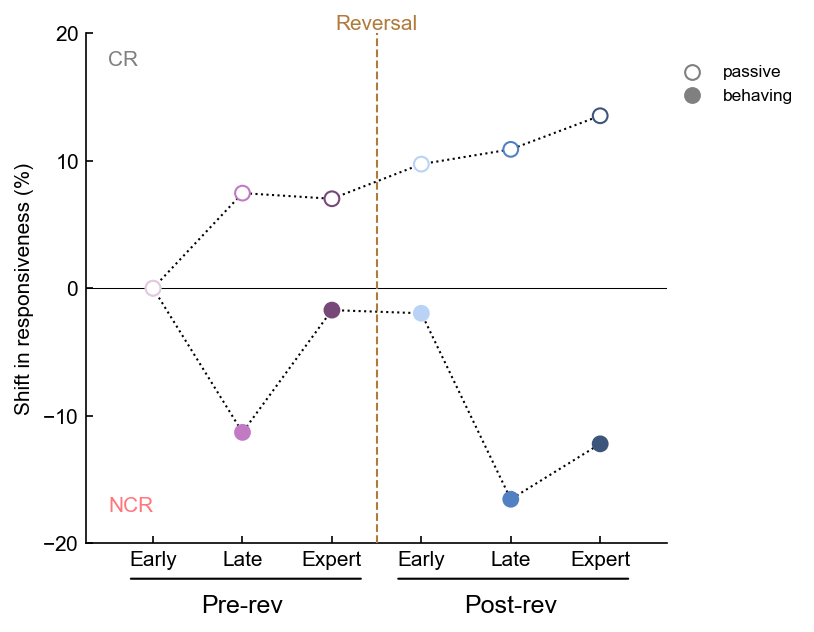

In [14]:
fig, ax = plt.subplots(figsize=(5,4.5))
labels = ['Early','Late','Expert','Early','Late','Expert']
#colors = phase_colors = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']

percentCR = np.array([FRmod_preearly_pc,FRmod_prelate_pc,FRmod_preexpert_pc,FRmod_postearly_pc,FRmod_postlate_pc,FRmod_postexpert_pc])*100
numCon = len(labels)
ax.plot([0,1,2,3,4,5],(percentCR-FRmod_preearly_pc*100),color='k',linestyle=':',lw=1,alpha=1)

color=NCR_CR_cmap((percentCR-40)/20)
ax.scatter([0,1,2,3,4,5],(percentCR-FRmod_preearly_pc*100),c=PHASE_COLORS,s=50,zorder=10,marker='o',lw=1)


percentCR = np.array([FRmod_passive_preearly_pc,FRmod_passive_prelate_pc,FRmod_passive_preexpert_pc,FRmod_passive_postearly_pc,FRmod_passive_postlate_pc,FRmod_passive_postexpert_pc])*100
ax.plot([0,1,2,3,4,5],(percentCR-FRmod_passive_preearly_pc*100),color='k',linestyle=':',lw=1,alpha=1)

color=NCR_CR_cmap((percentCR-40)/20)
ax.scatter(range(numCon),(percentCR-FRmod_passive_preearly_pc*100),fc='white',ec=PHASE_COLORS,s=50,zorder=10,marker='o',lw=1)















xlims = [-0.75,numCon-0.25]
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

#All cells with All Cells baseline
ax.set_ylabel('Shift in responsiveness (%)')
ax.set_ylim([-20,20])
ax.set_yticks([-20,-10,0,10,20])
ax.text(-0.5,17.5,'CR',color=CR_COLOR)
ax.text(-0.5,-17.5,'NCR',color=NCR_COLOR)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.axhline(0,c='k',linestyle='-',lw=0.5,zorder=-10)

ax.scatter([],[],fc='white',ec='grey',s=50,marker='o',lw=1,label='passive')
ax.scatter([],[],fc='grey',ec='grey',s=50,marker='o',lw=1,label='behaving')
lgd = ax.legend(frameon=False,loc=(1,0.85))

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+1
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.07, -0.07), xycoords='axes fraction', xytext=(0.48, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.94, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC Shift in responsiveness V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,t1,t2), bbox_inches='tight')

Text(2.5, 70.0, 'Reversal')

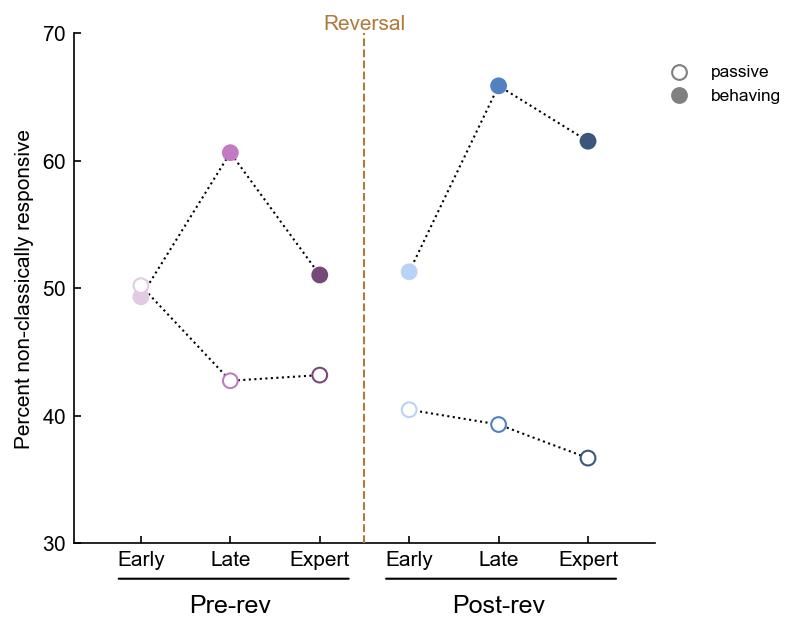

In [24]:
fig, ax = plt.subplots(figsize=(5,4.5))
labels = ['Early','Late','Expert','Early','Late','Expert']
#colors = phase_colors = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']

percentCR = np.array([FRmod_preearly_pc,FRmod_prelate_pc,FRmod_preexpert_pc,FRmod_postearly_pc,FRmod_postlate_pc,FRmod_postexpert_pc])*100
numCon = len(labels)
ax.plot([0,1,2],(100-percentCR[0:3]-0*FRmod_preearly_pc*100),color='k',linestyle=':',lw=1,alpha=1)
ax.plot([3,4,5],(100-percentCR[3:6]-0*FRmod_preearly_pc*100),color='k',linestyle=':',lw=1,alpha=1)

color=NCR_CR_cmap((percentCR-40)/20)
ax.scatter([0,1,2,3,4,5],(100-percentCR-0*FRmod_preearly_pc*100),c=PHASE_COLORS,s=50,zorder=10,marker='o',lw=1)


percentCR = np.array([FRmod_passive_preearly_pc,FRmod_passive_prelate_pc,FRmod_passive_preexpert_pc,FRmod_passive_postearly_pc,FRmod_passive_postlate_pc,FRmod_passive_postexpert_pc])*100
ax.plot([0,1,2],(100-percentCR[0:3]-0*FRmod_passive_preearly_pc*100),color='k',linestyle=':',lw=1,alpha=1)
ax.plot([3,4,5],(100-percentCR[3:6]-0*FRmod_passive_preearly_pc*100),color='k',linestyle=':',lw=1,alpha=1)

color=NCR_CR_cmap((percentCR-40)/20)
ax.scatter(range(numCon),(100-percentCR-0*FRmod_passive_preearly_pc*100),fc='white',ec=PHASE_COLORS,s=50,zorder=10,marker='o',lw=1)















xlims = [-0.75,numCon-0.25]
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

#All cells with All Cells baseline
ax.set_ylabel('Percent non-classically responsive')#
ax.set_ylim([30,70])
ax.set_yticks([30,40,50,60,70])
#ax.text(-0.5,17.5,'CR',color=CR_COLOR)
#ax.text(-0.5,-17.5,'NCR',color=NCR_COLOR)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.axhline(0,c='k',linestyle='-',lw=0.5,zorder=-10)

# ax.scatter([],[],fc='white',ec='grey',s=50,marker='o',lw=1,label='passive')
# ax.scatter([],[],fc='grey',ec='grey',s=50,marker='o',lw=1,label='behaving')
# lgd = ax.legend(frameon=False,loc=(1,0.85))

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+1
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.07, -0.07), xycoords='axes fraction', xytext=(0.48, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.94, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC Shift in responsiveness V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,t1,t2), bbox_inches='tight')

# Ramping

In [8]:
RampingNorm_preearly = []
RampingNorm_prelate = []
RampingNorm_preexpert = []
RampingNorm_postearly = []
RampingNorm_postlate = []
RampingNorm_postexpert = []

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
    if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
        #print('excluded')
        #continue
        pass
    
    rampingMod = sessionfile.responsiveness[clust]['go'].rampingMod
    if rampingMod <= 0:
        continue
        
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    if EILphases[idx] == 'pre early':
        RampingNorm_preearly.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
    elif EILphases[idx] == 'pre late':
        RampingNorm_prelate.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
    elif EILphases[idx] == 'pre expert':
        RampingNorm_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
    elif EILphases[idx] == 'post early':
        RampingNorm_postearly.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
    elif EILphases[idx] == 'post late':
        RampingNorm_postlate.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
    elif EILphases[idx] == 'post expert':
        RampingNorm_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)

RampingNorm_preearly = np.array(RampingNorm_preearly)
RampingNorm_prelate = np.array(RampingNorm_prelate)
RampingNorm_preexpert = np.array(RampingNorm_preexpert)
RampingNorm_postearly = np.array(RampingNorm_postearly)
RampingNorm_postlate = np.array(RampingNorm_postlate)
RampingNorm_postexpert = np.array(RampingNorm_postexpert)

1682it [00:19, 84.49it/s] 


In [9]:
RampingNorm_threshold = 0.5
print('baseline: '+str(RampingNorm_threshold))

#These numbers are essentially %CR
RampingNorm_preearly_pc = np.nanmean(np.greater(ilep.rmnan(np.abs(RampingNorm_preearly)),RampingNorm_threshold))
RampingNorm_prelate_pc = np.nanmean(np.greater(ilep.rmnan(np.abs(RampingNorm_prelate)),RampingNorm_threshold))
RampingNorm_preexpert_pc = np.nanmean(np.greater(ilep.rmnan(np.abs(RampingNorm_preexpert)),RampingNorm_threshold))
RampingNorm_postearly_pc = np.nanmean(np.greater(ilep.rmnan(np.abs(RampingNorm_postearly)),RampingNorm_threshold))
RampingNorm_postlate_pc = np.nanmean(np.greater(ilep.rmnan(np.abs(RampingNorm_postlate)),RampingNorm_threshold))
RampingNorm_postexpert_pc = np.nanmean(np.greater(ilep.rmnan(np.abs(RampingNorm_postexpert)),RampingNorm_threshold))
print(RampingNorm_preearly_pc)
print(RampingNorm_prelate_pc)
print(RampingNorm_preexpert_pc)
print(RampingNorm_postearly_pc)
print(RampingNorm_postlate_pc)
print(RampingNorm_postexpert_pc)

baseline: 0.5
0.24242424242424243
0.44761904761904764
0.6122448979591837
0.43884892086330934
0.5609756097560976
0.5384615384615384


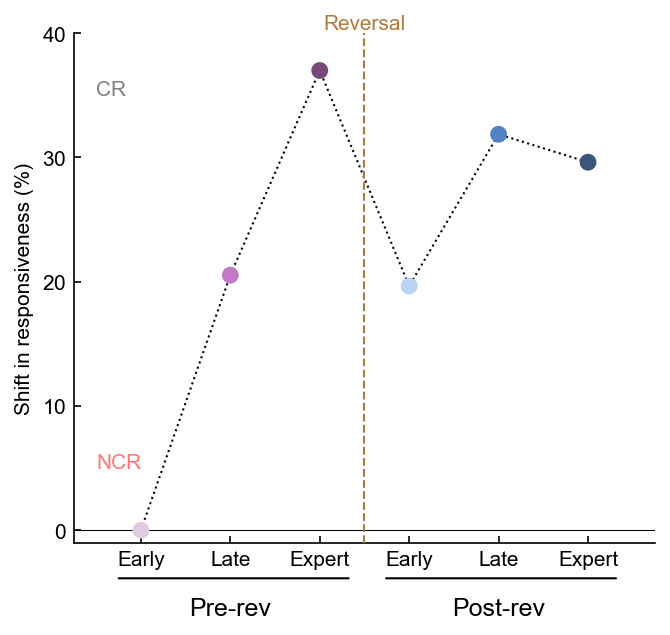

In [11]:
fig, ax = plt.subplots(figsize=(5,4.5))
labels = ['Early','Late','Expert','Early','Late','Expert']
#colors = phase_colors = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']

percentCR = np.array([RampingNorm_preearly_pc,RampingNorm_prelate_pc,RampingNorm_preexpert_pc,RampingNorm_postearly_pc,RampingNorm_postlate_pc,RampingNorm_postexpert_pc])*100
numCon = len(labels)
ax.plot([0,1,2,3,4,5],(percentCR-RampingNorm_preearly_pc*100),color='k',linestyle=':',lw=1,alpha=1)

color=NCR_CR_cmap((percentCR-40)/20)
ax.scatter([0,1,2,3,4,5],(percentCR-RampingNorm_preearly_pc*100),c=PHASE_COLORS,s=50,zorder=10,marker='o',lw=1)




xlims = [-0.75,numCon-0.25]
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

#All cells with All Cells baseline
ax.set_ylabel('Shift in responsiveness (%)')
ax.set_ylim([-1,40])
ax.set_yticks([0,10,20,30,40])
ax.text(-0.5,35,'CR',color=CR_COLOR)
ax.text(-0.5,5,'NCR',color=NCR_COLOR)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.axhline(0,c='k',linestyle='-',lw=0.5,zorder=-10)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+0.75
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.07, -0.07), xycoords='axes fraction', xytext=(0.48, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.94, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC Shift in ramping responsiveness V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(t1,t2), bbox_inches='tight')

In [28]:
FRmod_passive_preearly_pc

0.49795918367346936

# Percent NCR

In [43]:
pc_CR = [FRmod_preearly_pc,FRmod_prelate_pc,FRmod_preexpert_pc,FRmod_postearly_pc,FRmod_postlate_pc,FRmod_postexpert_pc]
pc_CR = np.array([100*d for d in pc_CR])
pc_NCR = np.array([100-d for d in pc_CR])

pc_CR_passive = [FRmod_passive_preearly_pc,FRmod_passive_prelate_pc,FRmod_passive_preexpert_pc,FRmod_passive_postearly_pc,FRmod_passive_postlate_pc,FRmod_passive_postexpert_pc]
pc_CR_passive = np.array([100*d for d in pc_CR_passive])
pc_NCR_passive = np.array([100-d for d in pc_CR_passive])

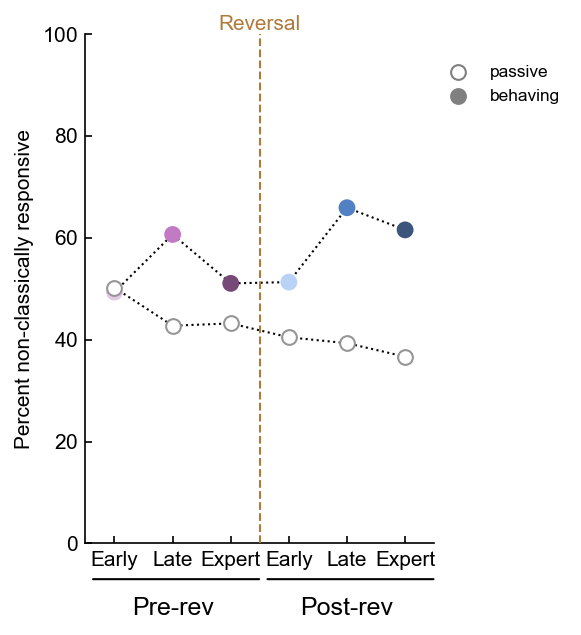

In [64]:
fig, ax = plt.subplots(figsize=(3,4.5))
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(labels)

ax.plot([0,1,2,3,4,5],(pc_NCR),color='k',linestyle=':',lw=1,alpha=1)
ax.scatter([0,1,2,3,4,5],(pc_NCR),c=PHASE_COLORS,s=50,zorder=10,marker='o',lw=1)

ax.plot([0,1,2,3,4,5],(pc_NCR_passive),color='k',linestyle=':',lw=1,alpha=1)
ax.scatter(range(numCon),(pc_NCR_passive),fc='white',ec=GOOD_GREY,s=50,zorder=10,marker='o',lw=1)






xlims = [-0.5,numCon-0.5]
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

#All cells with All Cells baseline
ax.set_ylabel('Percent non-classically responsive')
ax.set_ylim([0,100])
#ax.set_yticks([-20,-10,0,10,20])
#ax.text(-0.5,17.5,'CR',color=CR_COLOR)
#ax.text(-0.5,-17.5,'NCR',color=NCR_COLOR)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.scatter([],[],fc='white',ec='grey',s=50,marker='o',lw=1,label='passive')
ax.scatter([],[],fc='grey',ec='grey',s=50,marker='o',lw=1,label='behaving')
lgd = ax.legend(frameon=False,loc=(1,0.85))

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+2
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.01, -0.07), xycoords='axes fraction', xytext=(0.51, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.51, -0.07), xycoords='axes fraction', xytext=(1.01, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC percent NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,t1,t2), bbox_inches='tight')

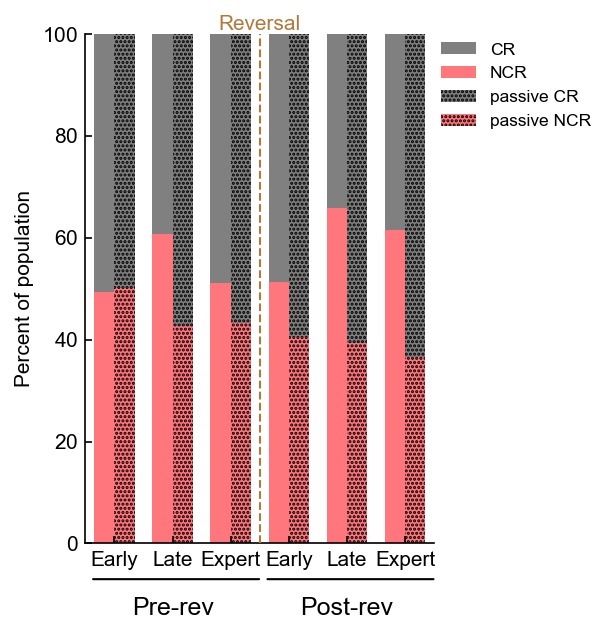

In [94]:
fig, ax = plt.subplots(figsize=(3,4.5))
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(labels)

# ax.plot([0,1,2,3,4,5],(pc_NCR),color='k',linestyle=':',lw=1,alpha=1)
# ax.scatter([0,1,2,3,4,5],(pc_NCR),c=PHASE_COLORS,s=50,zorder=10,marker='o',lw=1)

# ax.plot([0,1,2,3,4,5],(pc_NCR_passive),color='k',linestyle=':',lw=1,alpha=1)
# ax.scatter(range(numCon),(pc_NCR_passive),fc='white',ec=GOOD_GREY,s=50,zorder=10,marker='o',lw=1)

wid=0.35

X = np.array([0,1,2,3,4,5])-wid/2
ax.bar(X,pc_NCR,color=NCR_COLOR,width=wid)
ax.bar(X,pc_CR,bottom=pc_NCR,color=CR_COLOR,width=wid)

X = np.array([0,1,2,3,4,5])+wid/2
ax.bar(X,pc_NCR_passive,color=NCR_COLOR,width=wid,hatch='......')
ax.bar(X,pc_CR_passive,bottom=pc_NCR_passive,color=CR_COLOR,width=wid,hatch='......')




xlims = [-0.5,numCon-0.5]
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

#All cells with All Cells baseline
ax.set_ylabel('Percent of population')
ax.set_ylim([0,100])
#ax.set_yticks([-20,-10,0,10,20])
#ax.text(-0.5,17.5,'CR',color=CR_COLOR)
#ax.text(-0.5,-17.5,'NCR',color=NCR_COLOR)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.bar([np.nan],[np.nan],facecolor=CR_COLOR,label='CR')
ax.bar([np.nan],[np.nan],facecolor=NCR_COLOR,label='NCR')
ax.bar([np.nan],[np.nan],facecolor=CR_COLOR,hatch='......',label='passive CR')
ax.bar([np.nan],[np.nan],facecolor=NCR_COLOR,hatch='......',label='passive NCR')
lgd = ax.legend(frameon=False,loc=(1,0.8))

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+2
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.01, -0.07), xycoords='axes fraction', xytext=(0.51, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.51, -0.07), xycoords='axes fraction', xytext=(1.01, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC percent CR and NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,t1,t2), bbox_inches='tight')

In [14]:
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []

# RampingNorm_preearly = []
# RampingNorm_prelate = []
# RampingNorm_preexpert = []
# RampingNorm_postearly = []
# RampingNorm_postlate = []
# RampingNorm_postexpert = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
    if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
        #print('excluded')
        #continue
        pass
    
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
    
    if EILphases[idx] == 'pre early':
        FRmod_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
#         RampingNorm_preearly.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        FRmod_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
#         RampingNorm_prelate.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        FRmod_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
#         RampingNorm_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        FRmod_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
#         RampingNorm_postearly.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        FRmod_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
#         RampingNorm_postlate.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        FRmod_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
#         RampingNorm_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        postexpert_animals.append(sessionfile.meta.animal)

FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

# RampingNorm_preearly = np.array(RampingNorm_preearly)
# RampingNorm_prelate = np.array(RampingNorm_prelate)
# RampingNorm_preexpert = np.array(RampingNorm_preexpert)
# RampingNorm_postearly = np.array(RampingNorm_postearly)
# RampingNorm_postlate = np.array(RampingNorm_postlate)
# RampingNorm_postexpert = np.array(RampingNorm_postexpert)

1830it [00:27, 67.43it/s] 


In [14]:
print(len(FRmod_preearly))
print(len(FRmod_prelate))
print(len(FRmod_preexpert))
print(len(FRmod_postearly))
print(len(FRmod_postlate))
print(len(FRmod_postexpert))

148
188
117
306
342
262


In [32]:
len(animals)

15

# Calculate %NCR and SEM on an animal by animal basis

In [13]:
pc_NCR_preearly = []
pc_NCR_prelate = []
pc_NCR_preexpert = []
pc_NCR_postearly = []
pc_NCR_postlate = []
pc_NCR_postexpert = []

FR_preearly = []
FR_prelate = []
FR_preexpert = []
FR_postearly = []
FR_postlate = []
FR_postexpert = []

n_preearly = []
n_prelate = []
n_preexpert = []
n_postearly = []
n_postlate = []
n_postexpert = []

# FRmod_postearly_copy = []
# all_postearly_cells = dict()
# for animal in animals:
#     all_postearly_cells[animal] = []
# all_preearly_cells = dict()
# for animal in animals:
#     all_preearly_cells[animal] = []

for animal in animals:
    
    animal_FRmod_preearly = []
    animal_FRmod_prelate = []
    animal_FRmod_preexpert = []
    animal_FRmod_postearly = []
    animal_FRmod_postlate = []
    animal_FRmod_postexpert = []
    
    animal_n_preearly = 0
    animal_n_prelate = 0
    animal_n_preexpert = 0
    animal_n_postearly = 0
    animal_n_postlate = 0
    animal_n_postexpert = 0

    for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
        sessionfile = ilep.loadSessionCached(act_directory,session)
        
        if sessionfile.meta.animal != animal:
            continue
        if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
            continue
            
        try:
            FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        except Exception as e:
            print(f"session {session} cluster {clust} encountered error: {e}")
            FRmod = np.nan
        if np.isnan(FRmod):
            continue
        
        if EILphases[idx] == 'pre early':
#             all_preearly_cells[animal].append(FRmod)
            animal_FRmod_preearly.append(FRmod)
            animal_n_preearly += 1
        elif EILphases[idx] == 'pre late':
            animal_FRmod_prelate.append(FRmod)
            animal_n_prelate += 1
        elif EILphases[idx] == 'pre expert':
            animal_FRmod_preexpert.append(FRmod)
            animal_n_preexpert += 1
        elif EILphases[idx] == 'post early':
#             FRmod_postearly_copy.append(FRmod)
#             all_postearly_cells[animal].append(FRmod)
            animal_FRmod_postearly.append(FRmod)
            animal_n_postearly += 1
        elif EILphases[idx] == 'post late':
            animal_FRmod_postlate.append(FRmod)
            animal_n_postlate += 1
        elif EILphases[idx] == 'post expert':
            animal_FRmod_postexpert.append(FRmod)
            animal_n_postexpert += 1
       
    
#     pc_NCR_preearly.append(np.mean(np.less(ilep.rmnan(animal_FRmod_preearly),3.5)))
#     pc_NCR_prelate.append(np.mean(np.less(ilep.rmnan(animal_FRmod_prelate),3.5)))
#     pc_NCR_preexpert.append(np.mean(np.less(ilep.rmnan(animal_FRmod_preexpert),3.5)))
#     pc_NCR_postearly.append(np.mean(np.less(ilep.rmnan(animal_FRmod_postearly),3.5)))
#     pc_NCR_postlate.append(np.mean(np.less(ilep.rmnan(animal_FRmod_postlate),3.5)))
#     pc_NCR_postexpert.append(np.mean(np.less(ilep.rmnan(animal_FRmod_postexpert),3.5)))
    
    FR_preearly.append(animal_FRmod_preearly)
    FR_prelate.append(animal_FRmod_prelate)
    FR_preexpert.append(animal_FRmod_preexpert)
    FR_postearly.append(animal_FRmod_postearly)
    FR_postlate.append(animal_FRmod_postlate)
    FR_postexpert.append(animal_FRmod_postexpert)
    
    pc_NCR_preearly.append(np.mean(np.less(animal_FRmod_preearly,3.5)))
    pc_NCR_prelate.append(np.mean(np.less(animal_FRmod_prelate,3.5)))
    pc_NCR_preexpert.append(np.mean(np.less(animal_FRmod_preexpert,3.5)))
    pc_NCR_postearly.append(np.mean(np.less(animal_FRmod_postearly,3.5)))
    pc_NCR_postlate.append(np.mean(np.less(animal_FRmod_postlate,3.5)))
    pc_NCR_postexpert.append(np.mean(np.less(animal_FRmod_postexpert,3.5)))
    
    n_preearly.append(animal_n_preearly)
    n_prelate.append(animal_n_prelate)
    n_preexpert.append(animal_n_preexpert)
    n_postearly.append(animal_n_postearly)
    n_postlate.append(animal_n_postlate)
    n_postexpert.append(animal_n_postexpert)

1829it [00:27, 66.88it/s] 
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1829it [00:27, 66.82it/s] 
1829it [00:27, 66.92it/s] 
1829it [00:27, 66.87it/s] 
1829it [00:27, 66.92it/s] 
1829it [00:27, 66.87it/s] 
1829it [00:27, 66.87it/s] 
1829it [00:27, 67.12it/s] 
1829it [00:27, 67.17it/s] 
1829it [00:27, 67.07it/s] 
1829it [00:27, 67.02it/s] 
1829it [00:27, 67.13it/s] 
1829it [00:27, 66.99it/s] 
1829it [00:27, 66.94it/s] 
1829it [00:27, 67.14it/s] 


In [14]:
passive_pc_NCR_preearly = []
passive_pc_NCR_prelate = []
passive_pc_NCR_preexpert = []
passive_pc_NCR_postearly = []
passive_pc_NCR_postlate = []
passive_pc_NCR_postexpert = []

passive_FR_preearly = []
passive_FR_prelate = []
passive_FR_preexpert = []
passive_FR_postearly = []
passive_FR_postlate = []
passive_FR_postexpert = []

passive_n_preearly = []
passive_n_prelate = []
passive_n_preexpert = []
passive_n_postearly = []
passive_n_postlate = []
passive_n_postexpert = []

print(len(['TH_201','TH_203','LA_204','LA_205','TH_200', 'TH_230','AE_229','TH_233','TH_234','AE_294']))
for animal in ['TH_201','TH_203','LA_204','LA_205','TH_200', 'TH_230','AE_229','TH_233','TH_234','AE_294']:
    
    passive_animal_FRmod_preearly = []
    passive_animal_FRmod_prelate = []
    passive_animal_FRmod_preexpert = []
    passive_animal_FRmod_postearly = []
    passive_animal_FRmod_postlate = []
    passive_animal_FRmod_postexpert = []
    
    passive_animal_n_preearly = 0
    passive_animal_n_prelate = 0
    passive_animal_n_preexpert = 0
    passive_animal_n_postearly = 0
    passive_animal_n_postlate = 0
    passive_animal_n_postexpert = 0
    
    for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
        ACsessionfile = ilep.loadSessionCached(act_directory,session)
        
        if ACsessionfile.meta.animal != animal:
            continue
            
        if sessionfile.meta.region != 'AC':
            continue
            
        if session in ['TH_203_1_passive_AC.pickle','TH_203_4_passive_AC.pickle','TH_203_7_passive_AC.pickle','LA_204_2_passive_AC.pickle','LA_204_3_passive_AC.pickle','LA_204_4_passive_AC.pickle']:#Outlier sessions
            continue
            
        FRmod = ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation
        if np.isnan(FRmod):
            continue

        #1,2,3,4
        if ACsessionfile.meta.day_of_training <= pre_early:
            passive_animal_FRmod_preearly.append(FRmod)
            passive_animal_n_preearly += 1
        #5,6
        if ACsessionfile.meta.day_of_training <= pre_late and ACsessionfile.meta.day_of_training >pre_early:
            passive_animal_FRmod_prelate.append(FRmod)
            passive_animal_n_prelate += 1
        #7,8
        if ACsessionfile.meta.day_of_training <= pre_expert and ACsessionfile.meta.day_of_training >pre_late:
            passive_animal_FRmod_preexpert.append(FRmod)
            passive_animal_n_preexpert += 1
        #9,10,11,12
        if ACsessionfile.meta.day_of_training <= post_early and ACsessionfile.meta.day_of_training > pre_expert:
            passive_animal_FRmod_postearly.append(FRmod)
            passive_animal_n_postearly += 1
        #13,14,15
        if ACsessionfile.meta.day_of_training <= post_late and ACsessionfile.meta.day_of_training >post_early:
            passive_animal_FRmod_postlate.append(FRmod)
            passive_animal_n_postlate += 1
        #16,17,18,19,20,21
        if ACsessionfile.meta.day_of_training >= post_expert:
            passive_animal_FRmod_postexpert.append(FRmod)
            passive_animal_n_postexpert += 1
            
    if animal == 'TH_201':
        print(f"TH_201: {len(passive_animal_FRmod_preearly)}")
    if animal == 'TH_203':
        print(f"TH_203: {len(passive_animal_FRmod_preearly)}")
        
    if animal == 'LA_204':
        print(f"LA_204: {len(passive_animal_FRmod_preearly)}")
    if animal == 'LA_205':
        print(f"LA_205: {len(passive_animal_FRmod_preearly)}")
        
    passive_FR_preearly.append(passive_animal_FRmod_preearly)
    passive_FR_prelate.append(passive_animal_FRmod_prelate)
    passive_FR_preexpert.append(passive_animal_FRmod_preexpert)
    passive_FR_postearly.append(passive_animal_FRmod_postearly)
    passive_FR_postlate.append(passive_animal_FRmod_postlate)
    passive_FR_postexpert.append(passive_animal_FRmod_postexpert)
    
    passive_pc_NCR_preearly.append(np.mean(np.less(ilep.rmnan(passive_animal_FRmod_preearly),3.5)))
    passive_pc_NCR_prelate.append(np.mean(np.less(ilep.rmnan(passive_animal_FRmod_prelate),3.5)))
    passive_pc_NCR_preexpert.append(np.mean(np.less(ilep.rmnan(passive_animal_FRmod_preexpert),3.5)))
    passive_pc_NCR_postearly.append(np.mean(np.less(ilep.rmnan(passive_animal_FRmod_postearly),3.5)))
    passive_pc_NCR_postlate.append(np.mean(np.less(ilep.rmnan(passive_animal_FRmod_postlate),3.5)))
    passive_pc_NCR_postexpert.append(np.mean(np.less(ilep.rmnan(passive_animal_FRmod_postexpert),3.5)))
    
    passive_n_preearly.append(passive_animal_n_preearly)
    passive_n_prelate.append(passive_animal_n_prelate)
    passive_n_preexpert.append(passive_animal_n_preexpert)
    passive_n_postearly.append(passive_animal_n_postearly)
    passive_n_postlate.append(passive_animal_n_postlate)
    passive_n_postexpert.append(passive_animal_n_postexpert)

5it [00:00, 44.23it/s]

10


1608it [00:13, 123.05it/s]
5it [00:00, 44.24it/s]

TH_201: 161


1608it [00:13, 123.42it/s]
5it [00:00, 43.47it/s]

TH_203: 37


1608it [00:13, 122.90it/s]
5it [00:00, 45.03it/s]

LA_204: 0


1608it [00:13, 122.23it/s]
5it [00:00, 41.66it/s]

LA_205: 0


1608it [00:13, 122.58it/s]
1608it [00:13, 121.43it/s]
1608it [00:13, 120.10it/s]
1608it [00:13, 122.07it/s]
1608it [00:13, 122.44it/s]
1608it [00:13, 122.72it/s]


In [30]:
# mean_pc_NCR = np.array([np.mean(ilep.rmnan(d)) for d in [pc_NCR_preearly,pc_NCR_prelate,pc_NCR_preexpert,pc_NCR_postearly,pc_NCR_postlate,pc_NCR_postexpert]])*100
# mean_pc_NCR2 = np.array([np.nansum(np.array(d1)*np.array(d2))/np.nansum(d2) for d1,d2 in zip([pc_NCR_preearly,pc_NCR_prelate,pc_NCR_preexpert,pc_NCR_postearly,pc_NCR_postlate,pc_NCR_postexpert],[n_preearly,n_prelate,n_preexpert,n_postearly,n_postlate,n_postexpert])])*100
# sem_pc_NCR2 = np.array([sem(ilep.rmnan(d)) for d in [pc_NCR_preearly,pc_NCR_prelate,pc_NCR_preexpert,pc_NCR_postearly,pc_NCR_postlate,pc_NCR_postexpert]])*100

mean_pc_NCR = []
sem_pc_NCR = []
for FRmods in [FR_preearly,FR_prelate,FR_preexpert,FR_postearly,FR_postlate,FR_postexpert]:
    Mw,SEMw = ilep.bootstrap_Mw_SEMw(FRmods,n_frac=1,CR_NCR_thresh=3.5,hierarchical=True)
    mean_pc_NCR.append(Mw)
    sem_pc_NCR.append(SEMw)

In [31]:
# passive_mean_pc_NCR = np.array([np.mean(ilep.rmnan(d)) for d in [passive_pc_NCR_preearly,passive_pc_NCR_prelate,passive_pc_NCR_preexpert,passive_pc_NCR_postearly,passive_pc_NCR_postlate,passive_pc_NCR_postexpert]])*100
# passive_mean_pc_NCR2 = np.array([np.nansum(np.array(d1)*np.array(d2))/np.nansum(d2) for d1,d2 in zip([passive_pc_NCR_preearly,passive_pc_NCR_prelate,passive_pc_NCR_preexpert,passive_pc_NCR_postearly,passive_pc_NCR_postlate,passive_pc_NCR_postexpert],[passive_n_preearly,passive_n_prelate,passive_n_preexpert,passive_n_postearly,passive_n_postlate,passive_n_postexpert])])*100
# passive_sem_pc_NCR2 = np.array([sem(ilep.rmnan(d)) for d in [passive_pc_NCR_preearly,passive_pc_NCR_prelate,passive_pc_NCR_preexpert,passive_pc_NCR_postearly,passive_pc_NCR_postlate,passive_pc_NCR_postexpert]])*100

passive_mean_pc_NCR = []
passive_sem_pc_NCR = []
for FRmods in [passive_FR_preearly,passive_FR_prelate,passive_FR_preexpert,passive_FR_postearly,passive_FR_postlate,passive_FR_postexpert]:
    Mw,SEMw = ilep.bootstrap_Mw_SEMw(FRmods,n_frac=1,CR_NCR_thresh=3.5,hierarchical=True)
    passive_mean_pc_NCR.append(Mw)
    passive_sem_pc_NCR.append(SEMw)

In [17]:
np.sum(np.isfinite(np.concatenate(FR_preearly)))

148

In [18]:
np.sum(np.isfinite(np.concatenate(FR_prelate)))

187

In [19]:
np.sum(np.isfinite(np.concatenate(FR_preexpert)))

97

In [20]:
np.sum(np.isfinite(np.concatenate(FR_postearly)))

306

In [21]:
np.sum(np.isfinite(np.concatenate(FR_postlate)))

342

In [22]:
5

5

In [24]:
np.sum(np.isfinite(np.concatenate(passive_FR_preearly)))

198

In [25]:
np.sum(np.isfinite(np.concatenate(passive_FR_prelate)))

241

In [26]:
np.sum(np.isfinite(np.concatenate(passive_FR_preexpert)))

206

In [27]:
np.sum(np.isfinite(np.concatenate(passive_FR_postearly)))

244

In [28]:
np.sum(np.isfinite(np.concatenate(passive_FR_postlate)))

201

In [29]:
np.sum(np.isfinite(np.concatenate(passive_FR_postexpert)))

450

In [26]:
Xs = [FR_preearly,FR_prelate,FR_preexpert,FR_postearly,FR_postlate,FR_postexpert]
Ys = [passive_FR_preearly,passive_FR_prelate,passive_FR_preexpert,passive_FR_postearly,passive_FR_postlate,passive_FR_postexpert]

pvals = [np.nan]*6
for idx,(X,Y) in enumerate(zip(Xs,Ys)):
    pvals[idx] = ilep.bootstrap_pc_NCR_test(X,Y,CR_NCR_thresh=[3.5])
    print(pvals[idx])
    
_,pvals_corr = pg.multicomp(pvals,method='fdr_bh')
print()
print(pvals_corr)

0.879424
0.016871999999999998
0.16344800000000004
0.7088639999999999
0.0
8.000000000008e-06

[8.794240e-01 3.374400e-02 2.451720e-01 8.506368e-01 0.000000e+00
 2.400000e-05]


In [27]:
5

5

In [34]:
5

5

In [36]:
def bootstrap_pc_NCR_test(X,Y,B=250000,CR_NCR_thresh=[3.5],hierarchical=False):
    #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7906290/
    #Application of the hierarchical bootstrap to multi-level data in neuroscience
    #Saravanan et al.
    
    #Testing against the null hypothesis that these two groups are the same
    X = np.array(X)
    mask = np.greater([len(l) for l in X],0)
    X = X[mask]
    
    Y = np.array(Y)
    mask = np.greater([len(l) for l in Y],0)
    Y = Y[mask]

    #Handle differing CR NCR Thresholds. Scale up to 2 if only one is provided
    if len(CR_NCR_thresh) == 1:
        CR_NCR_thresh = [CR_NCR_thresh[0],CR_NCR_thresh[0]]
    
    MwX_list = []
    for idx_B in range(B):
        if hierarchical:
            this_sample_animals = []
            N = len(X)
            this_sample_animals = np.random.choice(X,N)
        else:
            this_sample_animals = X
        
        this_sample = []
        for this_list in this_sample_animals:
            n = len(this_list)
            sample = np.random.choice(this_list,n)
            this_sample.append(sample)
        
        this_pcs = [np.mean(np.less(X,CR_NCR_thresh[0])) for X in this_sample]
        this_sizes = [len(l) for l in this_sample]
        Mw = np.average(this_pcs,weights=this_sizes)
        MwX_list.append(Mw)
        
    MwY_list = []
    for idx_B in range(B):
        if hierarchical:
            this_sample_animals = []
            N = len(Y)
            this_sample_animals = np.random.choice(Y,N)
        else:
            this_sample_animals = Y
        
        this_sample = []
        for this_list in this_sample_animals:
            n = len(this_list)
            sample = np.random.choice(this_list,n)
            this_sample.append(sample)
        
        this_pcs = [np.mean(np.less(Y,CR_NCR_thresh[1])) for Y in this_sample]
        this_sizes = [len(l) for l in this_sample]
        Mw = np.average(this_pcs,weights=this_sizes)
        MwY_list.append(Mw)
        
    #Two-sided test
    diffs = (np.array(MwY_list) - np.array(MwX_list))
    pY = 1 - np.mean(np.greater(diffs,0))
    pX = 1 - np.mean(np.less(diffs,0))
    pboot = min(pX,pY)*2
    return pboot

In [37]:
Xs = [FR_preearly,FR_prelate,FR_preexpert,FR_postearly,FR_postlate,FR_postexpert]
Ys = [passive_FR_preearly,passive_FR_prelate,passive_FR_preexpert,passive_FR_postearly,passive_FR_postlate,passive_FR_postexpert]

pvals = [np.nan]*6
for idx,(X,Y) in enumerate(zip(Xs,Ys)):
    pvals[idx] = bootstrap_pc_NCR_test(X,Y,CR_NCR_thresh=[3.5],hierarchical=True)
    print(pvals[idx])
    
_,pvals_corr = pg.multicomp(pvals,method='fdr_bh')
print()
print(pvals_corr)

<ipython-input-36-4cf2484f2526>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)
<ipython-input-36-4cf2484f2526>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y = np.array(Y)


0.8630720000000001
0.3222320000000001
0.5141279999999999
0.91788
0.007511999999999963
0.028343999999999925

[0.91788  0.644464 0.771192 0.91788  0.045072 0.085032]


In [18]:
def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')

### V2

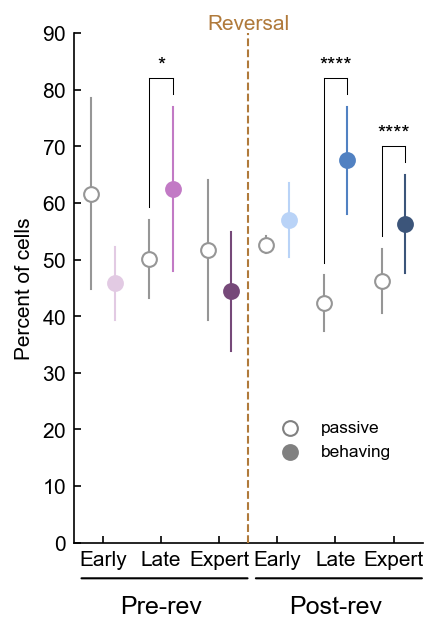

In [248]:
fig, ax = plt.subplots(figsize=(3,4.5))
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(labels)

#ax.scatter([0,1,2,3,4,5],(pc_NCR)/100,c=PHASE_COLORS,s=50,zorder=10,marker='o',lw=1)
#ax.scatter([0,1,2,3,4,5],(mean_pc_NCR_passive)/100,fc='white',ec=GOOD_GREY,s=50,zorder=9,marker='o',lw=1)

wid = 0.2

for idx in range(6):
    ax.scatter([idx-wid],(passive_mean_pc_NCR[idx]),fc='white',ec=GOOD_GREY,s=50,zorder=10,marker='o',lw=1)
    ax.plot([idx-wid,idx-wid],[(passive_mean_pc_NCR[idx]-passive_sem_pc_NCR[idx]),(passive_mean_pc_NCR[idx]+passive_sem_pc_NCR[idx])],color=GOOD_GREY,lw=1,zorder=9)
    
    ax.scatter([idx+wid],(mean_pc_NCR[idx]),c=PHASE_COLORS[idx],s=50,zorder=10,marker='o',lw=1)
    ax.plot([idx+wid,idx+wid],[(mean_pc_NCR[idx]-sem_pc_NCR[idx]),(mean_pc_NCR[idx]+sem_pc_NCR[idx])],color=PHASE_COLORS[idx],lw=1,zorder=9)
    
#ax.scatter([0,1,2,3,4,5],(mean_pc_NCR_passive)/100,fc='white',ec=GOOD_GREY,s=50,zorder=9,marker='o',lw=1)



xlims = [-0.5,numCon-0.5]
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

#All cells with All Cells baseline
ylab = ax.set_ylabel('Percent of cells')
ax.set_ylim([0,90])
#ax.set_yticks([0,25,50,75,90])
#ax.set_yticks([-20,-10,0,10,20])
#ax.text(-0.5,17.5,'CR',color=CR_COLOR)
#ax.text(-0.5,-17.5,'NCR',color=NCR_COLOR)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.scatter([],[],fc='white',ec='grey',s=50,marker='o',lw=1,label='passive')
ax.scatter([],[],fc='grey',ec='grey',s=50,marker='o',lw=1,label='behaving')
lgd = ax.legend(frameon=False,loc=(0.55,0.15))

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+2
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.01, -0.07), xycoords='axes fraction', xytext=(0.51, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.51, -0.07), xycoords='axes fraction', xytext=(1.01, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

statsbar(ax,82,[1-wid,1+wid],stemheights=[passive_mean_pc_NCR[1]+passive_sem_pc_NCR[1] , mean_pc_NCR[1]+sem_pc_NCR[1]],text='*',lw=0.5)
statsbar(ax,82,[4-wid,4+wid],stemheights=[passive_mean_pc_NCR[4]+passive_sem_pc_NCR[4] , mean_pc_NCR[4]+sem_pc_NCR[4]],text='****',lw=0.5)
statsbar(ax,70,[5-wid,5+wid],stemheights=[passive_mean_pc_NCR[5]+passive_sem_pc_NCR[5] , mean_pc_NCR[5]+sem_pc_NCR[5]],text='****',lw=0.5)

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC percent NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,ylab,t1,t2), bbox_inches='tight')

### V3

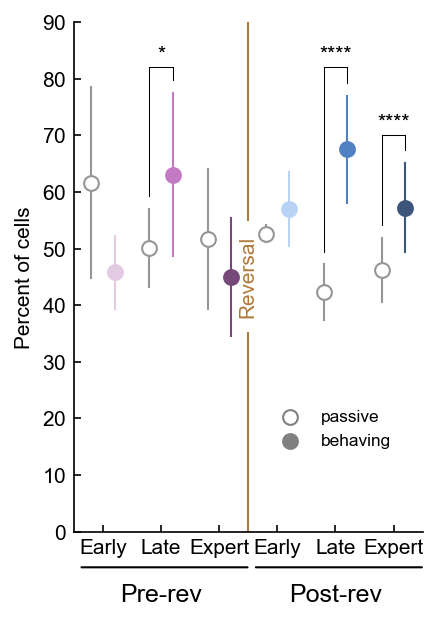

In [29]:
fig, ax = plt.subplots(figsize=(3,4.5))
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(labels)

#ax.scatter([0,1,2,3,4,5],(pc_NCR)/100,c=PHASE_COLORS,s=50,zorder=10,marker='o',lw=1)
#ax.scatter([0,1,2,3,4,5],(mean_pc_NCR_passive)/100,fc='white',ec=GOOD_GREY,s=50,zorder=9,marker='o',lw=1)

wid = 0.2

for idx in range(6):
    ax.scatter([idx-wid],(passive_mean_pc_NCR[idx]),fc='white',ec=GOOD_GREY,s=50,zorder=10,marker='o',lw=1)
    ax.plot([idx-wid,idx-wid],[(passive_mean_pc_NCR[idx]-passive_sem_pc_NCR[idx]),(passive_mean_pc_NCR[idx]+passive_sem_pc_NCR[idx])],color=GOOD_GREY,lw=1,zorder=9)
    
    ax.scatter([idx+wid],(mean_pc_NCR[idx]),c=PHASE_COLORS[idx],s=50,zorder=10,marker='o',lw=1)
    ax.plot([idx+wid,idx+wid],[(mean_pc_NCR[idx]-sem_pc_NCR[idx]),(mean_pc_NCR[idx]+sem_pc_NCR[idx])],color=PHASE_COLORS[idx],lw=1,zorder=9)
    
#ax.scatter([0,1,2,3,4,5],(mean_pc_NCR_passive)/100,fc='white',ec=GOOD_GREY,s=50,zorder=9,marker='o',lw=1)



xlims = [-0.5,numCon-0.5]
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

#All cells with All Cells baseline
ylab = ax.set_ylabel('Percent of cells')
ax.set_ylim([0,90])
#ax.set_yticks([0,25,50,75,90])
#ax.set_yticks([-20,-10,0,10,20])
#ax.text(-0.5,17.5,'CR',color=CR_COLOR)
#ax.text(-0.5,-17.5,'NCR',color=NCR_COLOR)

size = 10
rev = 2.5
center = np.mean(ax.get_ylim())
ax.text(rev,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
ax.plot([rev,rev],[ax.get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
ax.plot([rev,rev],[center+size,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')

ax.scatter([],[],fc='white',ec='grey',s=50,marker='o',lw=1,label='passive')
ax.scatter([],[],fc='grey',ec='grey',s=50,marker='o',lw=1,label='behaving')
lgd = ax.legend(frameon=False,loc=(0.55,0.15))

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+2
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.01, -0.07), xycoords='axes fraction', xytext=(0.51, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.51, -0.07), xycoords='axes fraction', xytext=(1.01, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

statsbar(ax,82,[1-wid,1+wid],stemheights=[passive_mean_pc_NCR[1]+passive_sem_pc_NCR[1] , mean_pc_NCR[1]+sem_pc_NCR[1]],text='*',lw=0.5)
statsbar(ax,82,[4-wid,4+wid],stemheights=[passive_mean_pc_NCR[4]+passive_sem_pc_NCR[4] , mean_pc_NCR[4]+sem_pc_NCR[4]],text='****',lw=0.5)
statsbar(ax,70,[5-wid,5+wid],stemheights=[passive_mean_pc_NCR[5]+passive_sem_pc_NCR[5] , mean_pc_NCR[5]+sem_pc_NCR[5]],text='****',lw=0.5)

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC percent NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,ylab,t1,t2), bbox_inches='tight')

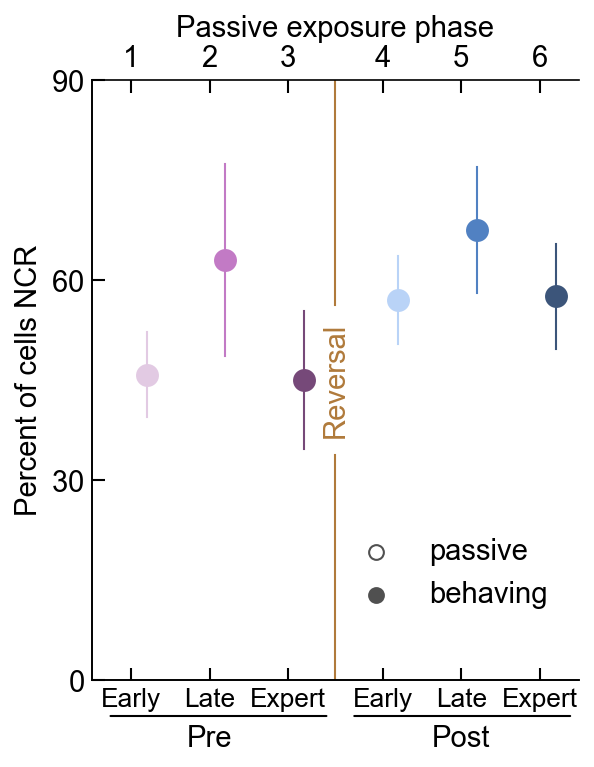

In [11]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.1

################################################################################################################

wid = 0.2

for idx,p in zip(range(6),[-1,-1,-1,1,1,1]):
#     ax.scatter([idx-wid+p*switch_offset],(passive_mean_pc_NCR[idx]),fc='white',ec=PASSIVE_COLOR,s=100,zorder=10,marker='o',lw=1)
#     ax.plot([idx-wid+p*switch_offset,idx-wid+p*switch_offset],[(passive_mean_pc_NCR[idx]-passive_sem_pc_NCR[idx]),(passive_mean_pc_NCR[idx]+passive_sem_pc_NCR[idx])],color=PASSIVE_COLOR,lw=1,zorder=9)
    
    ax.scatter([idx+wid+p*switch_offset],(mean_pc_NCR[idx]),c=PHASE_COLORS[idx],s=100,zorder=10,marker='o',lw=1)
    ax.plot([idx+wid+p*switch_offset,idx+wid+p*switch_offset],[(mean_pc_NCR[idx]-sem_pc_NCR[idx]),(mean_pc_NCR[idx]+sem_pc_NCR[idx])],color=PHASE_COLORS[idx],lw=1,zorder=9)
    
#ax.scatter([0,1,2,3,4,5],(mean_pc_NCR_passive)/100,fc='white',ec=GOOD_GREY,s=50,zorder=9,marker='o',lw=1)
# statsbar(ax,82,[1-wid-switch_offset,1+wid-switch_offset],stemheights=[passive_mean_pc_NCR[1]+passive_sem_pc_NCR[1] , mean_pc_NCR[1]+sem_pc_NCR[1]],text='*',lw=1)
# statsbar(ax,82,[4-wid+switch_offset,4+wid+switch_offset],stemheights=[passive_mean_pc_NCR[4]+passive_sem_pc_NCR[4] , mean_pc_NCR[4]+sem_pc_NCR[4]],text='****',lw=1)
# statsbar(ax,70,[5-wid+switch_offset,5+wid+switch_offset],stemheights=[passive_mean_pc_NCR[5]+passive_sem_pc_NCR[5] , mean_pc_NCR[5]+sem_pc_NCR[5]],text='****',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
labels2 = [1,2,3,4,5,6]

ylab = ax.set_ylabel('Percent of cells NCR')
ax.set_ylim([0,90])
ax.set_yticks([0,30,60,90])
              
ax.set_xlim([-0.5-switch_offset,5.5+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

ax2 = ax.twiny()
ax2.spines['top'].set_visible(True)
ax2.get_xaxis().set_visible(True)
ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax2.set_xticklabels(labels2)
xlab2 = ax2.set_xlabel('Passive exposure phase')
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
    ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(stdfont)

ax.scatter([], [], ec=PASSIVE_COLOR,fc='white', s=50,lw=1,marker='o',label='passive')
ax.scatter([], [], ec=PASSIVE_COLOR,fc=PASSIVE_COLOR, s=50,lw=1,marker='o',label='behaving')
ax.legend(frameon=False,loc=(0.5,0.1),fontsize=14)

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC percent NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

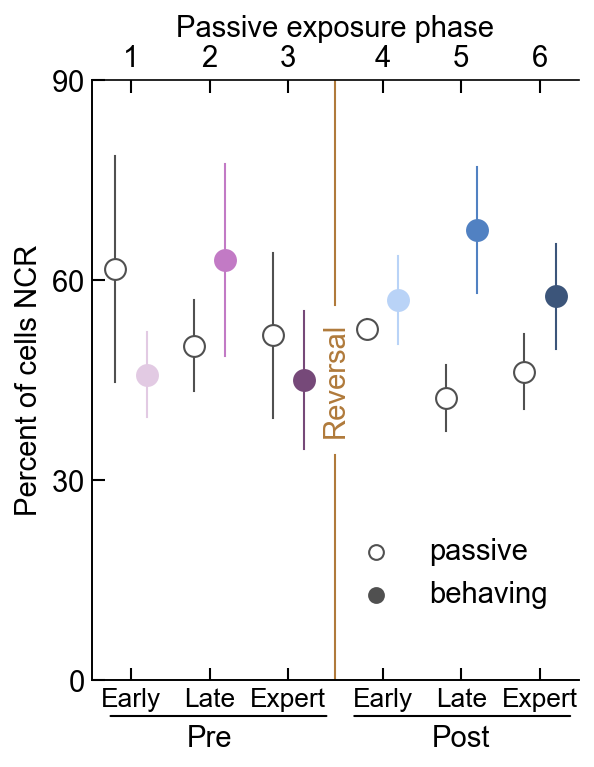

In [40]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.1

################################################################################################################

wid = 0.2

for idx,p in zip(range(6),[-1,-1,-1,1,1,1]):
    ax.scatter([idx-wid+p*switch_offset],(passive_mean_pc_NCR[idx]),fc='white',ec=PASSIVE_COLOR,s=100,zorder=10,marker='o',lw=1)
    ax.plot([idx-wid+p*switch_offset,idx-wid+p*switch_offset],[(passive_mean_pc_NCR[idx]-passive_sem_pc_NCR[idx]),(passive_mean_pc_NCR[idx]+passive_sem_pc_NCR[idx])],color=PASSIVE_COLOR,lw=1,zorder=9)
    
    ax.scatter([idx+wid+p*switch_offset],(mean_pc_NCR[idx]),c=PHASE_COLORS[idx],s=100,zorder=10,marker='o',lw=1)
    ax.plot([idx+wid+p*switch_offset,idx+wid+p*switch_offset],[(mean_pc_NCR[idx]-sem_pc_NCR[idx]),(mean_pc_NCR[idx]+sem_pc_NCR[idx])],color=PHASE_COLORS[idx],lw=1,zorder=9)
    
#ax.scatter([0,1,2,3,4,5],(mean_pc_NCR_passive)/100,fc='white',ec=GOOD_GREY,s=50,zorder=9,marker='o',lw=1)
# statsbar(ax,82,[1-wid-switch_offset,1+wid-switch_offset],stemheights=[passive_mean_pc_NCR[1]+passive_sem_pc_NCR[1] , mean_pc_NCR[1]+sem_pc_NCR[1]],text='*',lw=1)
# statsbar(ax,82,[4-wid+switch_offset,4+wid+switch_offset],stemheights=[passive_mean_pc_NCR[4]+passive_sem_pc_NCR[4] , mean_pc_NCR[4]+sem_pc_NCR[4]],text='****',lw=1)
# statsbar(ax,70,[5-wid+switch_offset,5+wid+switch_offset],stemheights=[passive_mean_pc_NCR[5]+passive_sem_pc_NCR[5] , mean_pc_NCR[5]+sem_pc_NCR[5]],text='****',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
labels2 = [1,2,3,4,5,6]

ylab = ax.set_ylabel('Percent of cells NCR')
ax.set_ylim([0,90])
ax.set_yticks([0,30,60,90])
              
ax.set_xlim([-0.5-switch_offset,5.5+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

ax2 = ax.twiny()
ax2.spines['top'].set_visible(True)
ax2.get_xaxis().set_visible(True)
ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax2.set_xticklabels(labels2)
xlab2 = ax2.set_xlabel('Passive exposure phase')
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
    ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(stdfont)

ax.scatter([], [], ec=PASSIVE_COLOR,fc='white', s=50,lw=1,marker='o',label='passive')
ax.scatter([], [], ec=PASSIVE_COLOR,fc=PASSIVE_COLOR, s=50,lw=1,marker='o',label='behaving')
ax.legend(frameon=False,loc=(0.5,0.1),fontsize=14)

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC percent NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

## Weighted

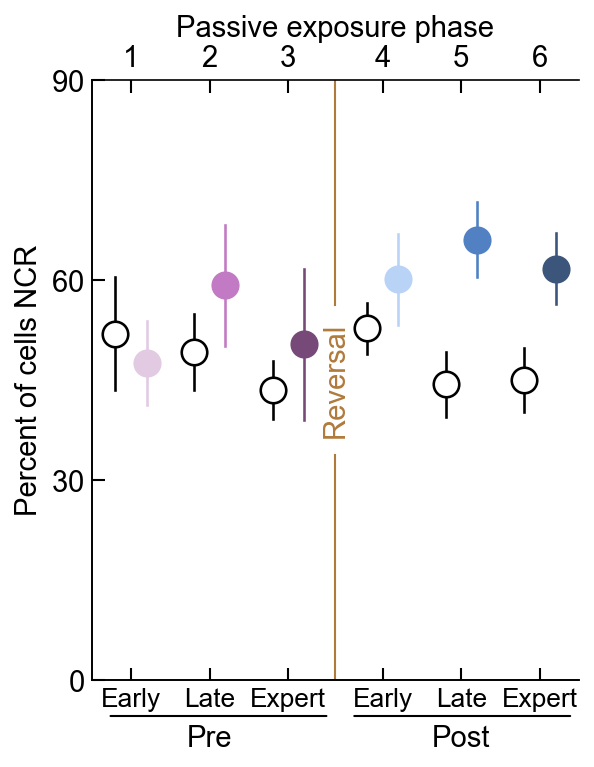

In [21]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.1

################################################################################################################

wid = 0.2

for idx,p in zip(range(6),[-1,-1,-1,1,1,1]):
    ax.scatter([idx-wid+p*switch_offset],(passive_mean_pc_NCR[idx]),fc='white',ec=PASSIVE_COLOR,s=150,zorder=10,marker='o',lw=1.25)
    ax.plot([idx-wid+p*switch_offset,idx-wid+p*switch_offset],[(passive_mean_pc_NCR[idx]-passive_sem_pc_NCR[idx]),(passive_mean_pc_NCR[idx]+passive_sem_pc_NCR[idx])],color=PASSIVE_COLOR,lw=1.25,zorder=9)
    
    ax.scatter([idx+wid+p*switch_offset],(mean_pc_NCR[idx]),c=PHASE_COLORS[idx],s=150,zorder=10,marker='o',lw=1.25)
    ax.plot([idx+wid+p*switch_offset,idx+wid+p*switch_offset],[(mean_pc_NCR[idx]-sem_pc_NCR[idx]),(mean_pc_NCR[idx]+sem_pc_NCR[idx])],color=PHASE_COLORS[idx],lw=1.25,zorder=9)
    
#ax.scatter([0,1,2,3,4,5],(mean_pc_NCR_passive)/100,fc='white',ec=GOOD_GREY,s=50,zorder=9,marker='o',lw=1)
# statsbar(ax,82,[1-wid-switch_offset,1+wid-switch_offset],stemheights=[passive_mean_pc_NCR[1]+passive_sem_pc_NCR[1] , mean_pc_NCR[1]+sem_pc_NCR[1]],text='*',lw=1)
# statsbar(ax,82,[4-wid+switch_offset,4+wid+switch_offset],stemheights=[passive_mean_pc_NCR[4]+passive_sem_pc_NCR[4] , mean_pc_NCR[4]+sem_pc_NCR[4]],text='****',lw=1)
# statsbar(ax,70,[5-wid+switch_offset,5+wid+switch_offset],stemheights=[passive_mean_pc_NCR[5]+passive_sem_pc_NCR[5] , mean_pc_NCR[5]+sem_pc_NCR[5]],text='****',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
labels2 = [1,2,3,4,5,6]

ylab = ax.set_ylabel('Percent of cells NCR')
ax.set_ylim([0,90])
ax.set_yticks([0,30,60,90])
              
ax.set_xlim([-0.5-switch_offset,5.5+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

ax2 = ax.twiny()
ax2.spines['top'].set_visible(True)
ax2.get_xaxis().set_visible(True)
ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax2.set_xticklabels(labels2)
xlab2 = ax2.set_xlabel('Passive exposure phase')
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
    ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(stdfont)

# ax.scatter([], [], ec=PASSIVE_COLOR,fc='white', s=50,lw=1,marker='o',label='passive')
# ax.scatter([], [], ec=PASSIVE_COLOR,fc=PASSIVE_COLOR, s=50,lw=1,marker='o',label='behaving')
# ax.legend(frameon=False,loc=(0.5,0.1),fontsize=14)

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC percent NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

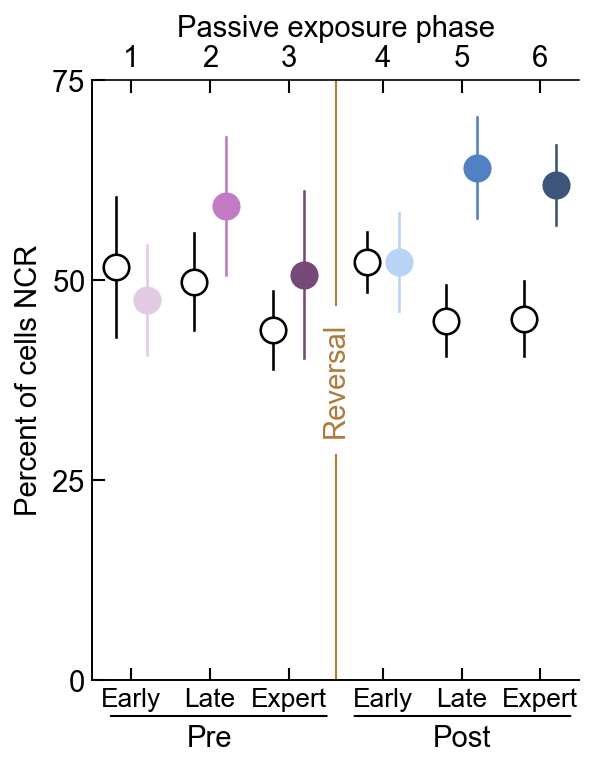

In [32]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.1

################################################################################################################

wid = 0.2

for idx,p in zip(range(6),[-1,-1,-1,1,1,1]):
    ax.scatter([idx-wid+p*switch_offset],(passive_mean_pc_NCR[idx]),fc='white',ec=PASSIVE_COLOR,s=150,zorder=10,marker='o',lw=1.25)
    ax.plot([idx-wid+p*switch_offset,idx-wid+p*switch_offset],[(passive_mean_pc_NCR[idx]-passive_sem_pc_NCR[idx]),(passive_mean_pc_NCR[idx]+passive_sem_pc_NCR[idx])],color=PASSIVE_COLOR,lw=1.25,zorder=9)
    
    ax.scatter([idx+wid+p*switch_offset],(mean_pc_NCR[idx]),c=PHASE_COLORS[idx],s=150,zorder=10,marker='o',lw=1.25)
    ax.plot([idx+wid+p*switch_offset,idx+wid+p*switch_offset],[(mean_pc_NCR[idx]-sem_pc_NCR[idx]),(mean_pc_NCR[idx]+sem_pc_NCR[idx])],color=PHASE_COLORS[idx],lw=1.25,zorder=9)
    
#ax.scatter([0,1,2,3,4,5],(mean_pc_NCR_passive)/100,fc='white',ec=GOOD_GREY,s=50,zorder=9,marker='o',lw=1)
# statsbar(ax,82,[1-wid-switch_offset,1+wid-switch_offset],stemheights=[passive_mean_pc_NCR[1]+passive_sem_pc_NCR[1] , mean_pc_NCR[1]+sem_pc_NCR[1]],text='*',lw=1)
# statsbar(ax,82,[4-wid+switch_offset,4+wid+switch_offset],stemheights=[passive_mean_pc_NCR[4]+passive_sem_pc_NCR[4] , mean_pc_NCR[4]+sem_pc_NCR[4]],text='****',lw=1)
# statsbar(ax,70,[5-wid+switch_offset,5+wid+switch_offset],stemheights=[passive_mean_pc_NCR[5]+passive_sem_pc_NCR[5] , mean_pc_NCR[5]+sem_pc_NCR[5]],text='****',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
labels2 = [1,2,3,4,5,6]

ylab = ax.set_ylabel('Percent of cells NCR')
ax.set_ylim([0,75])
ax.set_yticks([0,25,50,75])
              
ax.set_xlim([-0.5-switch_offset,5.5+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

ax2 = ax.twiny()
ax2.spines['top'].set_visible(True)
ax2.get_xaxis().set_visible(True)
ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax2.set_xticklabels(labels2)
xlab2 = ax2.set_xlabel('Passive exposure phase')
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
    ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(stdfont)

# ax.scatter([], [], ec=PASSIVE_COLOR,fc='white', s=50,lw=1,marker='o',label='passive')
# ax.scatter([], [], ec=PASSIVE_COLOR,fc=PASSIVE_COLOR, s=50,lw=1,marker='o',label='behaving')
# ax.legend(frameon=False,loc=(0.5,0.1),fontsize=14)

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC percent NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [62]:
mean_pc_NCR

[49.27432432432432,
 60.83957219251338,
 51.29381443298969,
 51.442156862745094,
 63.99502923976609,
 62.74655870445345]

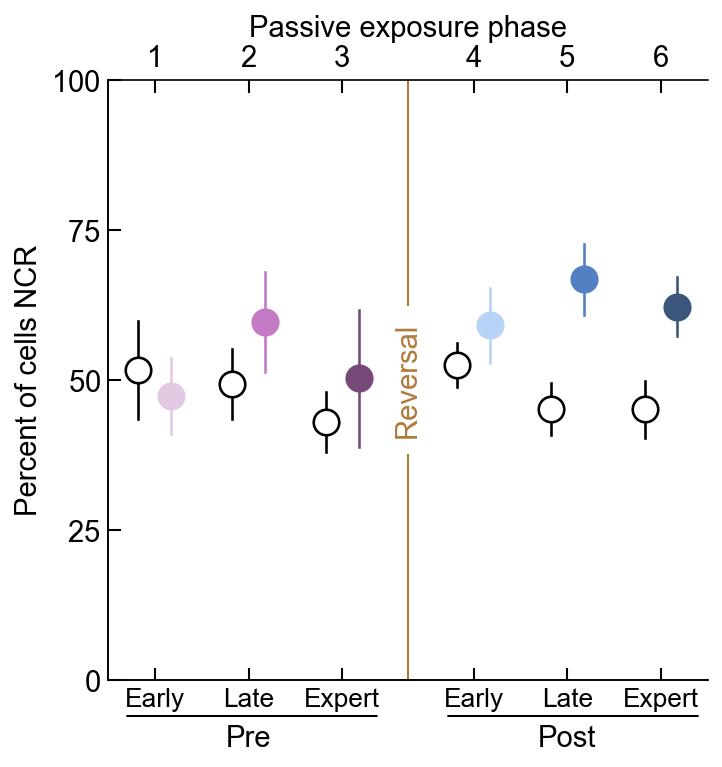

In [18]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')

fig,ax = make_axis_size(4, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.2

################################################################################################################

wid = 0.175

for idx,p in zip(range(6),[-1,-1,-1,1,1,1]):
    ax.scatter([idx-wid+p*switch_offset],(passive_mean_pc_NCR[idx]),fc='white',ec=PASSIVE_COLOR,s=150,zorder=10,marker='o',lw=1.25)
    ax.plot([idx-wid+p*switch_offset,idx-wid+p*switch_offset],[(passive_mean_pc_NCR[idx]-passive_sem_pc_NCR[idx]),(passive_mean_pc_NCR[idx]+passive_sem_pc_NCR[idx])],color=PASSIVE_COLOR,lw=1.25,zorder=9)
    
    ax.scatter([idx+wid+p*switch_offset],(mean_pc_NCR[idx]),c=PHASE_COLORS[idx],s=150,zorder=10,marker='o',lw=1.25)
    ax.plot([idx+wid+p*switch_offset,idx+wid+p*switch_offset],[(mean_pc_NCR[idx]-sem_pc_NCR[idx]),(mean_pc_NCR[idx]+sem_pc_NCR[idx])],color=PHASE_COLORS[idx],lw=1.25,zorder=9)
    
#ax.scatter([0,1,2,3,4,5],(mean_pc_NCR_passive)/100,fc='white',ec=GOOD_GREY,s=50,zorder=9,marker='o',lw=1)
# statsbar(ax,82,[1-wid-switch_offset,1+wid-switch_offset],stemheights=[passive_mean_pc_NCR[1]+passive_sem_pc_NCR[1] , mean_pc_NCR[1]+sem_pc_NCR[1]],text='*',lw=1)
# statsbar(ax,82,[4-wid+switch_offset,4+wid+switch_offset],stemheights=[passive_mean_pc_NCR[4]+passive_sem_pc_NCR[4] , mean_pc_NCR[4]+sem_pc_NCR[4]],text='****',lw=1)
# statsbar(ax,70,[5-wid+switch_offset,5+wid+switch_offset],stemheights=[passive_mean_pc_NCR[5]+passive_sem_pc_NCR[5] , mean_pc_NCR[5]+sem_pc_NCR[5]],text='****',lw=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
labels2 = [1,2,3,4,5,6]

ylab = ax.set_ylabel('Percent of cells NCR')
ax.set_ylim([0,100])
ax.set_yticks([0,25,50,75,100])
              
ax.set_xlim([-0.5-switch_offset,5.5+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)

ax2 = ax.twiny()
ax2.spines['top'].set_visible(True)
ax2.get_xaxis().set_visible(True)
ax2.set_xlim([-0.5-switch_offset,5.5+switch_offset])
ax2.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax2.set_xticklabels(labels2)
xlab2 = ax2.set_xlabel('Passive exposure phase')
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.025, -stdyfrac), xycoords='axes fraction', xytext=(0.455, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.56, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
ax2.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
    ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(stdfont)

# ax.scatter([], [], ec=PASSIVE_COLOR,fc='white', s=50,lw=1,marker='o',label='passive')
# ax.scatter([], [], ec=PASSIVE_COLOR,fc=PASSIVE_COLOR, s=50,lw=1,marker='o',label='behaving')
# ax.legend(frameon=False,loc=(0.5,0.1),fontsize=14)

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC percent NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [106]:
current_version

6

In [148]:
FRmod_data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]

In [ ]:
bootstrapped_distribution

In [50]:
def bootstrapped_distribution(data,func,sample_frac=1.0,iterations=400):
    sample_num = int(len(data)*sample_frac)
    
    sample_results = []
    for it in range(iterations):
        sample = np.random.choice(data,size=sample_num,replace=True)
        sample_results.append(func(sample))
        
    return np.mean(sample_results),sem(sample_results)

In [84]:
bootstrapped_distribution(FRmod_data[0],lambda x: np.mean(np.greater_equal(x,3.5)),sample_frac=0.25,iterations=10)

(0.44054054054054054, 0.018918918918918913)

In [87]:
animal = 'TH_203'

In [92]:
for idx,session in tqdm(enumerate(np.unique(EnumACSession))):
    
    sessionfile = ilep.loadSessionCached(act_directory,session)

    if sessionfile.meta.animal != animal:
        continue
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue

    FRmods = []
    for clust in sessionfile.clusters.good:
        cell_mod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        FRmods.append(cell_mod)
        
    print(f"session {session} is {100-np.mean(np.greater_equal(FRmods,3.5))*100}% NCR with {len(FRmods)} cells")
    

pc_NCR_preearly.append(np.mean(np.less(ilep.rmnan(animal_FRmod_preearly),3.5)))
pc_NCR_prelate.append(np.mean(np.less(ilep.rmnan(animal_FRmod_prelate),3.5)))
pc_NCR_preexpert.append(np.mean(np.less(ilep.rmnan(animal_FRmod_preexpert),3.5)))
pc_NCR_postearly.append(np.mean(np.less(ilep.rmnan(animal_FRmod_postearly),3.5)))
pc_NCR_postlate.append(np.mean(np.less(ilep.rmnan(animal_FRmod_postlate),3.5)))
pc_NCR_postexpert.append(np.mean(np.less(ilep.rmnan(animal_FRmod_postexpert),3.5)))

50it [00:00, 176.64it/s]

session TH_203_1_passive_AC.pickle is 80.76923076923077% NCR with 26 cells
session TH_203_2_passive_AC.pickle is 64.0% NCR with 25 cells
session TH_203_3_passive_AC.pickle is 66.66666666666667% NCR with 12 cells
session TH_203_4_passive_AC.pickle is 100.0% NCR with 21 cells
session TH_203_5_passive_AC.pickle is 67.85714285714286% NCR with 28 cells
session TH_203_7_passive_AC.pickle is 86.36363636363636% NCR with 22 cells
